In [61]:
# !pip install perceval-quandela
# !pip install tqdm

In [62]:
import perceval as pcvl
import numpy as np
from math import comb
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm as tqdm

In [63]:
string_data = """[ 0.77906588 -0.76810665 -0.70952121 -0.10329458  0.01653869  1.71044208
 -2.06329674  0.34302051  0.16591862 -0.33274983  1.38453705  0.28984149
  2.22382829  1.41968165 -0.14941414  0.92014096 -0.27692556 -2.12975672
 -1.004129   -2.27664009 -0.39683148 -0.75996755 -1.1545081  -1.17097078
 -0.93028365  0.84129417 -0.03508131 -1.82762447  0.89413013  0.06938348
  1.88483793  2.23257446 -2.07144239 -0.75485845 -0.15124521 -0.03847969
 -2.75795137  0.32089005  0.92429563 -2.6223639  -1.36580767  0.17225463
  0.20995315  1.01937141  0.11202505 -0.35774287  0.74750981  1.34879166
 -0.10895038  0.15874462  2.15033752  1.05962159  1.09921753  0.50830548
  0.54427547 -0.86354298  0.44476255  0.15440227  1.17829862  2.59909716
  0.54896993 -1.09466822 -0.83382506 -1.51921852  1.37481247  1.95094466
 -0.73873338  0.40306034  0.55467516 -0.10571769  0.02643511  0.60914473
  0.24616544  2.6583402  -1.28959374 -0.49372365  0.19254223 -0.1333773
 -0.83673556 -1.29110202  1.94477635  1.39953215 -0.61482809  3.09459544
 -0.05394472  0.3483397   0.33791449  0.94506944  0.38703945 -0.27931347
  0.03576284  0.9319657   1.64613832  0.50987978 -2.22340513  0.33293273
 -1.17184198 -3.07234135  1.46814947 -0.52782363]"""
# Remove brackets and split the string into individual values
values = string_data.strip('[]').split()

# Convert the string values to float and create a numpy array
best_param_from_string = np.array([float(value) for value in values])
# print(best_param_from_string)

In [64]:
nphotons = 5

# random_seed = np.random.randint(0, 10000)
random_seed = 6732
np.random.seed(random_seed)
print("Random Seed:", random_seed)

Random Seed: 6732


In [65]:
# Modeling parameters
n_grid = 50    # number of grid points of the discretized differential equation
range_min = 0  # minimum of the interval on which we wish to approximate our function
range_max = 2  # maximum of the interval on which we wish to approximate our function
X = np.linspace(range_min, range_max-range_min, n_grid)  # Optimisation grid

In [66]:
# Boundary condition 
coefii = 10

# del_0 = 0  #del
# omega_0 = 0     #w
# del_0_v = -1/coefii
# omega_0_v = 383.9911/coefii
del_0_v = 0.05193905464887731
omega_0_v = 37.70096706353524

In [67]:
# Differential equation parameters
ws = 376.9911

# ws = 0.376
# coefii = ws/4
K1 = 5/coefii
K2 = 10/coefii
K3 = 1.7/coefii
ws = ws/coefii

# def F(u_zegond,u_prime, u, x):       # DE, works with numpy arrays
#     return u_zegond+np.sin(x)
def F(u_zegond,u_prime, u, x):       # DE, works with numpy arrays
    # print(len(u_zegond))
    # print(len(u_prime))
    # print(len(u))
    delta = u
    delta_prime = u_prime
    omega = delta_prime+ws
    omega_prime = u_zegond
    return (delta_prime+ws-omega)+omega_prime-K1+K2*np.sin(coefii*delta)+K3*(-ws+omega)*coefii

In [68]:
# # Boundary condition (f(x_0)=f_0)
# x_0 = 0
# f_0 = np.sin(0)

In [69]:
# Differential equation's exact solution - for comparison
def u(x):
    return np.sin(x)

In [70]:
# Parameters of the quantum machine learning procedure
N = nphotons              # Number of photons
m = nphotons              # Number of modes
eta = 5                   # weight granted to the initial condition
a = 200                   # Approximate boundaries of the interval that the image of the trial function can cover
fock_dim = comb(N + m - 1, N)
# lambda coefficients for all the possible outputs
lambda_random = 2 * a * np.random.rand(fock_dim) - a
# dx serves for the numerical differentiation of f
dx = (range_max-range_min) / (n_grid - 1)

In [71]:
# Input state with N photons and m modes
input_state = pcvl.BasicState([1]*N+[0]*(m-N))
print(input_state)

|1,1,1,1,1>


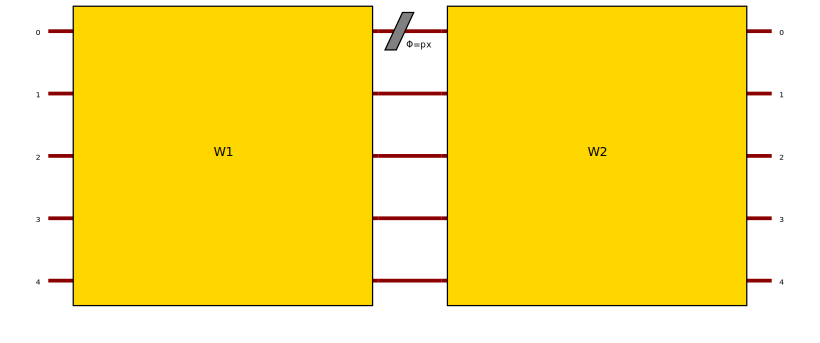

In [72]:
from perceval.simulators import Simulator
from perceval.backends import SLOSBackend

"Haar unitary parameters"
# number of parameters used for the two universal interferometers (2*m**2 per interferometer)
parameters = np.random.normal(size=4*m**2)

px = pcvl.P("px")
c = pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[:2 * m ** 2]), name="W1")\
     // (0, pcvl.PS(px))\
     // pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[2 * m ** 2:]), name="W2")


backend = pcvl.BackendFactory().get_backend("SLOS")
backend.set_circuit(pcvl.Unitary(pcvl.Matrix.random_unitary(m)))
backend.preprocess([input_state])

pcvl.pdisplay(c)

In [73]:
# best_param = np.load('./seed='+str(random_seed)+' n_photon='+str(nphotons)+'.npy')
# best_param = np.load('seed=5429 n_photon=4 range=0-1 ngrid 50.npy')
best_param =best_param_from_string
print("Unitary parameters", best_param)



Unitary parameters [ 0.77906588 -0.76810665 -0.70952121 -0.10329458  0.01653869  1.71044208
 -2.06329674  0.34302051  0.16591862 -0.33274983  1.38453705  0.28984149
  2.22382829  1.41968165 -0.14941414  0.92014096 -0.27692556 -2.12975672
 -1.004129   -2.27664009 -0.39683148 -0.75996755 -1.1545081  -1.17097078
 -0.93028365  0.84129417 -0.03508131 -1.82762447  0.89413013  0.06938348
  1.88483793  2.23257446 -2.07144239 -0.75485845 -0.15124521 -0.03847969
 -2.75795137  0.32089005  0.92429563 -2.6223639  -1.36580767  0.17225463
  0.20995315  1.01937141  0.11202505 -0.35774287  0.74750981  1.34879166
 -0.10895038  0.15874462  2.15033752  1.05962159  1.09921753  0.50830548
  0.54427547 -0.86354298  0.44476255  0.15440227  1.17829862  2.59909716
  0.54896993 -1.09466822 -0.83382506 -1.51921852  1.37481247  1.95094466
 -0.73873338  0.40306034  0.55467516 -0.10571769  0.02643511  0.60914473
  0.24616544  2.6583402  -1.28959374 -0.49372365  0.19254223 -0.1333773
 -0.83673556 -1.29110202  1.94477

In [74]:
def plot_solution(m, N, X, optim_params, lambda_random,label):
    Y = []
    U_1 = pcvl.Matrix.random_unitary(m, optim_params[:2 * m ** 2])
    U_2 = pcvl.Matrix.random_unitary(m, optim_params[2 * m ** 2:])
    px = pcvl.P("x")
    c = pcvl.Unitary(U_2) // (0, pcvl.PS(px)) // pcvl.Unitary(U_1)

    for x in X:
        px.set_value(np.pi * x/range_max)
        # U = c.compute_unitary(use_symbolic=False)
        # backend.U = U
        backend.set_circuit(c)
        f_theta = np.sum(np.multiply(backend.all_prob(input_state), lambda_random))
        Y.append(f_theta)

    print(Y[-1])
    print(Y)
    plt.plot(X, Y, label=label+" Approximation with {} photons".format(N))
    return Y

In [75]:

y_delta_real = [0.05216136499018766, 0.052233414609440296, 0.05230183865816158, 0.052365296488162204, 0.05242422046871254, 0.052478974116433846, 0.05252880797249117, 0.05257311597062473, 0.05261143543714994, 0.052643447090957377, 0.052668975043512804, 0.05268798679885716, 0.05270059325360658, 0.052707048696952336, 0.05270775081066093, 0.05270324066907401, 0.05269420273910841, 0.05268146488025614, 0.052665920683856886, 0.0526473731487284, 0.052626015140679244, 0.05260233986969308, 0.052576823617876786, 0.05254992573946048, 0.0525220886607975, 0.0524937378803644, 0.05246528196876095, 0.05243711256871016, 0.052409604395058255, 0.05238311523477468, 0.0523579859469521, 0.052334540462806424, 0.052313085785676755, 0.05229391199102544, 0.05227729222643804, 0.05226340144651936, 0.05225173160064383, 0.05224221277795755, 0.05223489563690745, 0.05222979502400428, 0.05222688997382269, 0.052226123709001135, 0.05222740364024196, 0.052230601366311344, 0.05223555267403931, 0.05224205753831974, 0.05224988012211037, 0.052258748776432794, 0.05226835604037243, 0.05227835864107858]
y_omega_real = [37.700857364463126, 37.700785451145684, 37.70069654790304, 37.70059596356713, 37.70048373649418, 37.70035924678862, 37.70022534677643, 37.70008472183375, 37.69993989038687, 37.69979320391226, 37.699646846936524, 37.69950283703645, 37.699363024838945, 37.69922909402112, 37.69910256131021, 37.69898477648363, 37.69887692236893, 37.69878001484385, 37.698694716317014, 37.698619219814425, 37.69855373261965, 37.69849914729103, 37.698456112970455, 37.698425035383366, 37.69840607683875, 37.698399156229165, 37.698403949030705, 37.69841988730304, 37.69844615968936, 37.69848171141645, 37.698525244294615, 37.69857521671772, 37.69862984366321, 37.69868709669205, 37.69874470394877, 37.69880063232652, 37.698856892139375, 37.69891328021577, 37.69896882622888, 37.699022669882964, 37.699074060913404, 37.69912235908665, 37.69916703420025, 37.69920766608286, 37.69924394459422, 37.69927566962516, 37.6993027510976, 37.69932520896457, 37.69934317321018, 37.69935688384964]
# y_delta_real = [0.06270473368439487, 0.06440608100297197, 0.06579860227220188, 0.06688397458981586, 0.06766697173651122, 0.06815699584387097, 0.06836679035269275, 0.06831244001298876, 0.06801337088398586, 0.0674923503341255, 0.06677548704106373, 0.06588997707084021, 0.06485645809353077, 0.06370215749208916, 0.06245420338757911, 0.06113854911865885, 0.05977997324158107, 0.05840207953019294, 0.05702729697593621, 0.055676879787846904, 0.054370858781088535, 0.0531254299565318, 0.051956470713585064, 0.05087876786781341, 0.04990420770296036, 0.049041775970947846, 0.048297557891876154, 0.04767473815402402, 0.047173600913848604, 0.046792125793543686, 0.04652866942406928, 0.04637970024674231, 0.0463401854166804, 0.04640371167246847, 0.04656248533615875, 0.046807332313270736, 0.04712769809279125, 0.04751164774717438, 0.04794586593234153, 0.04842011752856758, 0.0489263068279313, 0.04945259983437081, 0.04998813857634616, 0.05052305513057222, 0.0510484716220187, 0.05155650022391017, 0.052040243157726006, 0.05249379269320044, 0.05291223114832256, 0.05329164943677623]
# y_omega_real = [37.741262109883955, 37.73422129062033, 37.72716221474015, 37.720188592549555, 37.71340287506769, 37.70689923314973, 37.70075790762878, 37.69504520931588, 37.68981351900003, 37.685101287448155, 37.68093303540512, 37.677321797595106, 37.674285674349626, 37.671836336991255, 37.6699759187517, 37.66869760395643, 37.66798562802463, 37.66781527746926, 37.668152889896994, 37.668955854008274, 37.67017288898342, 37.67176248630506, 37.67367938189226, 37.67587025186054, 37.67828218036159, 37.68086265958334, 37.68355958974987, 37.6863212791215, 37.689096443994735, 37.691838096219435, 37.694510234405996, 37.69706894488453, 37.699475666732795, 37.70169846080984, 37.70371200975599, 37.70549761799283, 37.70704321172325, 37.708343338931414, 37.70939916938274, 37.71021438661233, 37.71079057842195, 37.71113389744162, 37.71125353326506, 37.71116170363727, 37.7108736544546, 37.710407659764705, 37.70978502176653, 37.70903007081035, 37.70817016539776, 37.707235190613275]


Text(0, 0.5, 'del_t')

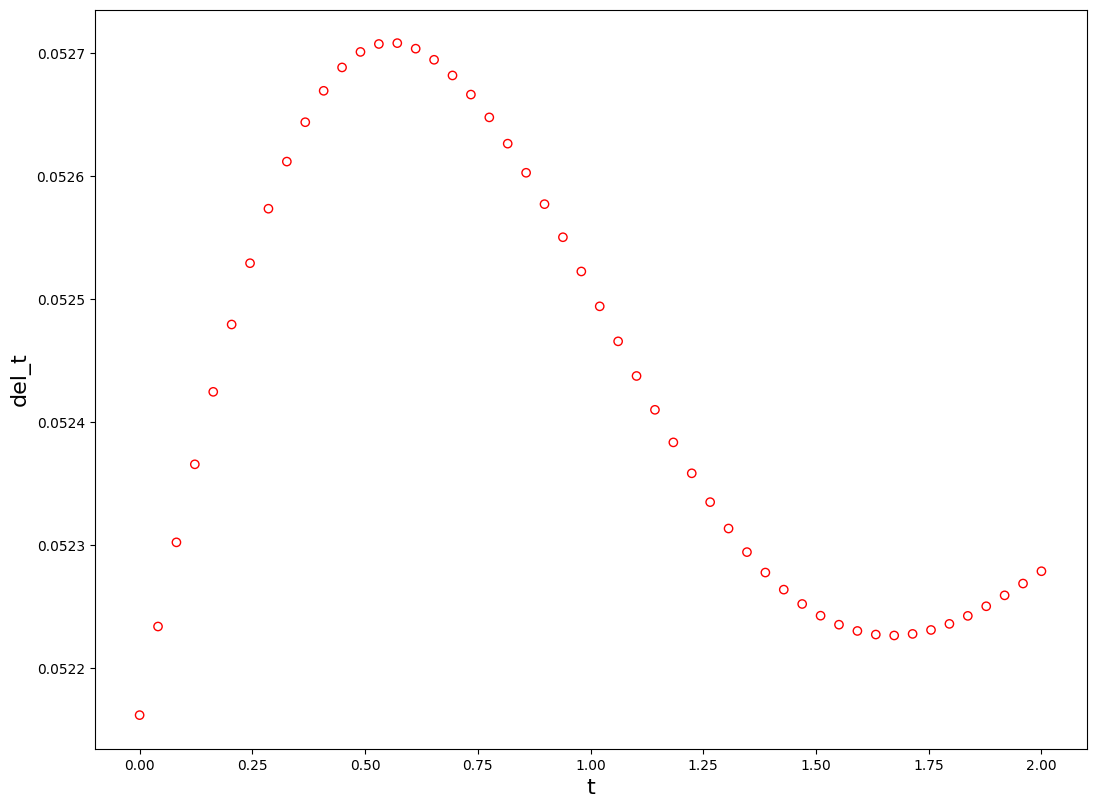

In [76]:
plt.figure()

plt.scatter(X,y_delta_real,facecolors='none', edgecolors='r', label='True - del_t')
# plt.scatter(X,pred_train_X, color='red',marker="x",s=4,label='Prediction - del_t')
plt.xlabel('t',fontsize=16)
plt.ylabel('del_t',fontsize=16)

0.05225051001698827
[0.0518976733949138, 0.05197753181219533, 0.05205946778522344, 0.05214074865257615, 0.05221955722712382, 0.0522947719943988, 0.05236574167668542, 0.052432079530809445, 0.05249349672103734, 0.052549686760182096, 0.052600265237078614, 0.05264476172284421, 0.05268265463463216, 0.05271343551079767, 0.052736686952115, 0.0527521584867368, 0.052759826637872764, 0.05275992911046937, 0.05275296769372331, 0.052739679537587264, 0.052720981229083023, 0.052697893961785175, 0.05267146059304384, 0.05264266624110301, 0.0526123732300811, 0.052581278808196526, 0.05254990050220644, 0.052518589739745554, 0.05248757006259651, 0.05245699247485679, 0.052426997757929764, 0.05239777434383586, 0.05236960078955233, 0.05234286403540299, 0.052318048239985704, 0.05229569363616268, 0.052276329966374976, 0.052260393960810045, 0.052248144335053426, 0.05223959029191039, 0.0522344500519252, 0.052232154255667324, 0.05223190517720924, 0.05223279683076923, 0.05223399375996879, 0.052234958299959056, 0.05

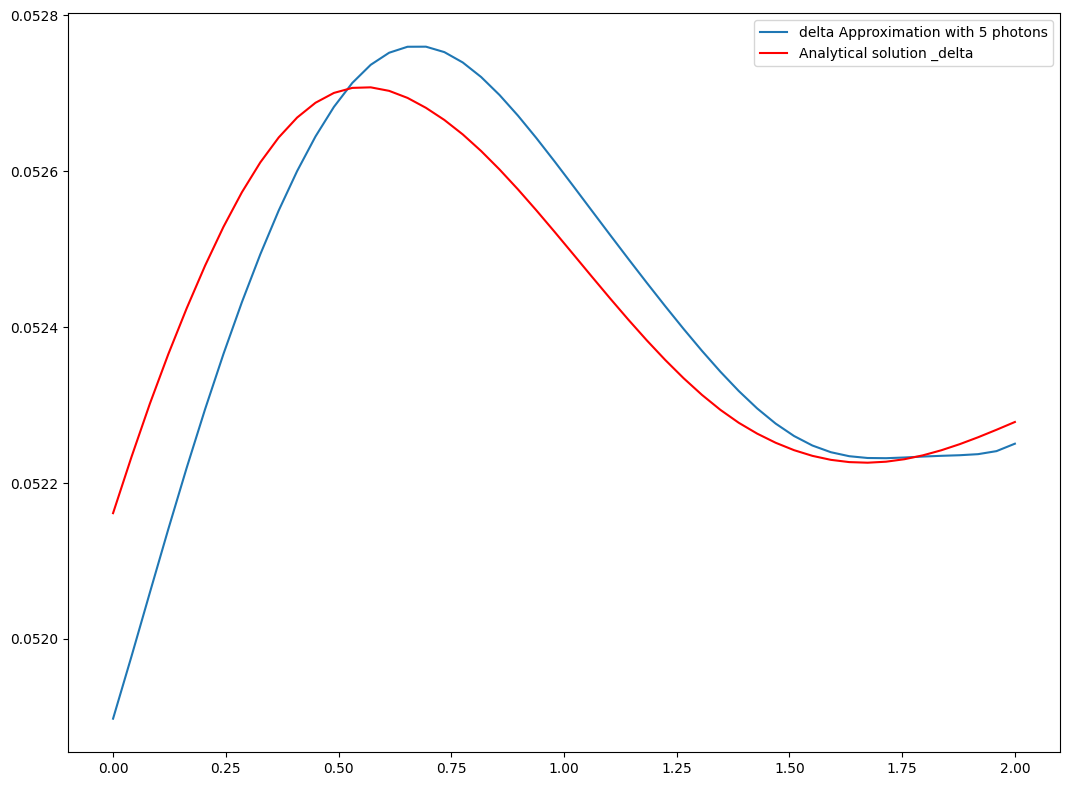

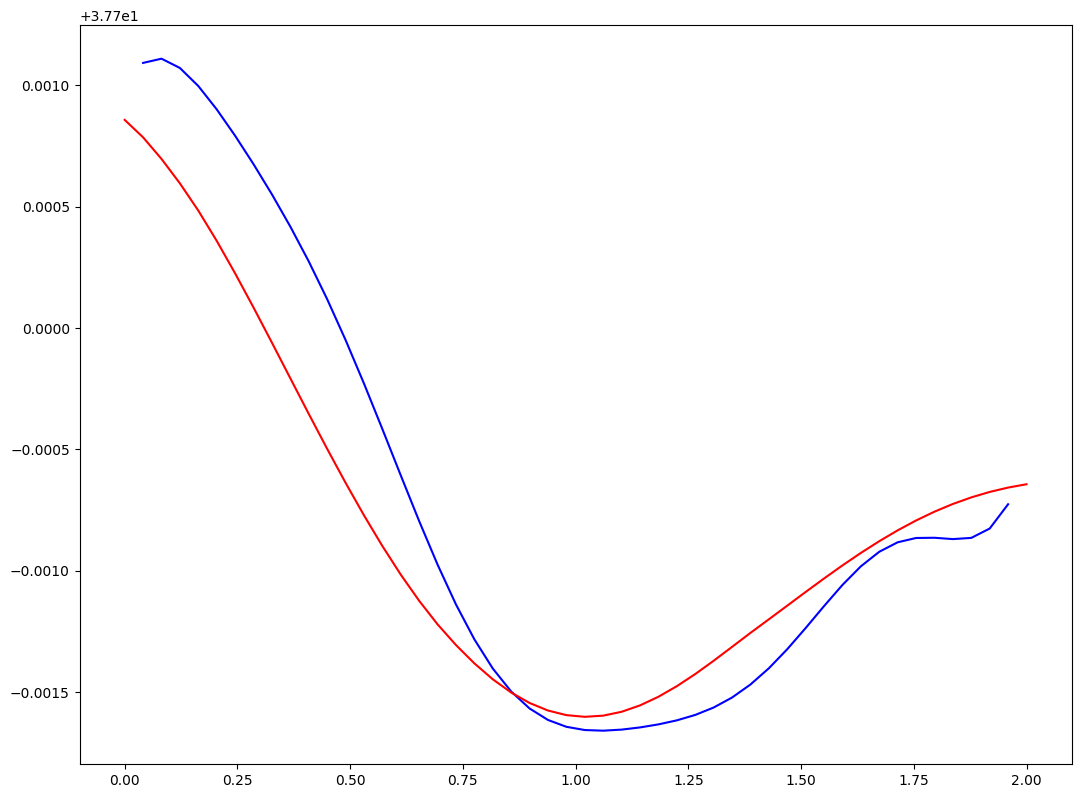

In [77]:
# X = np.linspace(range_min, range_max, 50)

# Change the plot size
default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [2 * value for value in default_figsize]

# delta_pred = plot_solution(m, N, X, res.x, lambda_random,'delta')
delta_pred = plot_solution(m, N, X, best_param, lambda_random,'delta')

plt.plot(X, y_delta_real, 'r', label='Analytical solution _delta')
plt.legend()

plt.figure()

delta_pred = np.array(delta_pred)
delta_prime = (delta_pred[2:] - delta_pred[:-2])/(2*dx)
omega = delta_prime+ws
plt.plot(X[1:-1], omega, 'b', label='prediction solution _omega')
plt.plot(X, y_omega_real, 'r', label='Analytical solution _omega')
# plt.legend()

print(omega[-1])
print(omega.tolist())
plt.show()

In [78]:

plt.plot([v[0] for v in loss_evolution])
plt.yscale("log")
plt.xlabel("Number of epochs")
plt.ylabel("Loss function value")

NameError: name 'loss_evolution' is not defined